Import required modules

In [1]:
from astropy.io import ascii, fits
import pylab as plt
%matplotlib inline
from astropy import wcs


import numpy as np
import xidplus
from xidplus import moc_routines
import pickle

Set image and catalogue filenames

In [2]:
#Folder containing maps

pswfits='/Users/pdh21/astrodata/COSMOS/P4/COSMOS-Nest_image_250_SMAP_v6.0.fits'#SPIRE 250 map
pmwfits='/Users/pdh21/astrodata/COSMOS/P4/COSMOS-Nest_image_350_SMAP_v6.0.fits'#SPIRE 350 map
plwfits='/Users/pdh21/astrodata/COSMOS/P4/COSMOS-Nest_image_500_SMAP_v6.0.fits'#SPIRE 500 map




#output folder
output_folder='./'

Load in images, noise maps, header info and WCS information

In [3]:
#-----250-------------
hdulist = fits.open(pswfits)
im250phdu=hdulist[0].header
im250hdu=hdulist[1].header

im250=hdulist[1].data*1.0E3 #convert to mJy
nim250=hdulist[2].data*1.0E3 #convert to mJy
w_250 = wcs.WCS(hdulist[1].header)
pixsize250=3600.0*w_250.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()
#-----350-------------
hdulist = fits.open(pmwfits)
im350phdu=hdulist[0].header
im350hdu=hdulist[1].header

im350=hdulist[1].data*1.0E3 #convert to mJy
nim350=hdulist[2].data*1.0E3 #convert to mJy
w_350 = wcs.WCS(hdulist[1].header)
pixsize350=3600.0*w_350.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()
#-----500-------------
hdulist = fits.open(plwfits)
im500phdu=hdulist[0].header
im500hdu=hdulist[1].header 
im500=hdulist[1].data*1.0E3 #convert to mJy
nim500=hdulist[2].data*1.0E3 #convert to mJy
w_500 = wcs.WCS(hdulist[1].header)
pixsize500=3600.0*w_500.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()

Load in catalogue you want to fit (and make any cuts)

In [4]:
from astropy.table import Table

In [5]:
photoz=Table.read('/Users/pdh21/astrodata/COSMOS/P4/COSMOS2015-HELP_selected_20160613_photoz_v1.0.fits')

Ken Duncan defines a median and a hierarchical bayes combination redshift. We take first peak if it exists

In [6]:
z_sig=np.empty((len(photoz)))
z_median=np.empty((len(photoz)))
for i in range(0,len(photoz)):
    z_sig[i]=np.max(np.array([photoz['z1_median'][i]-photoz['z1_min'][i],photoz['z1_max'][i]-photoz['z1_median'][i]]))
    if photoz['z1_median'][i] > 0.0:
        z_median[i]=photoz['z1_median'][i]
    else:
        z_median[i]=photoz['za_hb'][i]

XID+ uses Multi Order Coverage (MOC) maps for cutting down maps and catalogues so they cover the same area. It can also take in MOCs as selection functions to carry out additional cuts. Lets use the python module [pymoc](http://pymoc.readthedocs.io/en/latest/) to create a MOC, centered on a specific position we are interested in. We will use a HEALPix order of 15 (the resolution: higher order means higher resolution), have a radius of 100 arcseconds centered around an R.A. of 150.487 degrees and Declination of 2.396 degrees.

In [7]:
from astropy.coordinates import SkyCoord
from astropy import units as u

c = SkyCoord(ra=[150.486514739]*u.degree, dec=[2.39576363026]*u.degree)

import pymoc
moc=pymoc.util.catalog.catalog_to_moc(c,50,15)

XID+ is built around two python classes. A prior and posterior class. There should be a prior class for each map being fitted. It is initiated with a map, noise map, primary header and map header and can be set with a MOC. It also requires an input prior catalogue and point spread function.


In [8]:
#---prior250--------
prior250=xidplus.prior(im250,nim250,im250phdu,im250hdu, moc=moc)#Initialise with map, uncertianty map, wcs info and primary header
prior250.prior_cat(photoz['RA'],photoz['DEC'],'photoz', z_median=z_median, z_sig=z_sig)#Set input catalogue
prior250.prior_bkg(-5.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)
#---prior350--------
prior350=xidplus.prior(im350,nim350,im350phdu,im350hdu, moc=moc)
prior350.prior_cat(photoz['RA'],photoz['DEC'],'photoz', z_median=z_median, z_sig=z_sig)
prior350.prior_bkg(-5.0,5)

#---prior500--------
prior500=xidplus.prior(im500,nim500,im500phdu,im500hdu, moc=moc)
prior500.prior_cat(photoz['RA'],photoz['DEC'],'photoz', z_median=z_median, z_sig=z_sig)
prior500.prior_bkg(-5.0,5)

Set PSF. For SPIRE, the PSF can be assumed to be Gaussian with a FWHM of 18.15, 25.15, 36.3 '' for 250, 350 and 500 $\mathrm{\mu m}$ respectively. Lets use the astropy module to construct a Gaussian PSF and assign it to the three XID+ prior classes.

In [9]:
#pixsize array (size of pixels in arcseconds)
pixsize=np.array([pixsize250,pixsize350,pixsize500])
#point response function for the three bands
prfsize=np.array([18.15,25.15,36.3])
#use Gaussian2DKernel to create prf (requires stddev rather than fwhm hence pfwhm/2.355)
from astropy.convolution import Gaussian2DKernel

##---------fit using Gaussian beam-----------------------
prf250=Gaussian2DKernel(prfsize[0]/2.355,x_size=101,y_size=101)
prf250.normalize(mode='peak')
prf350=Gaussian2DKernel(prfsize[1]/2.355,x_size=101,y_size=101)
prf350.normalize(mode='peak')
prf500=Gaussian2DKernel(prfsize[2]/2.355,x_size=101,y_size=101)
prf500.normalize(mode='peak')

pind250=np.arange(0,101,1)*1.0/pixsize[0] #get 250 scale in terms of pixel scale of map
pind350=np.arange(0,101,1)*1.0/pixsize[1] #get 350 scale in terms of pixel scale of map
pind500=np.arange(0,101,1)*1.0/pixsize[2] #get 500 scale in terms of pixel scale of map

prior250.set_prf(prf250.array,pind250,pind250)#requires psf as 2d grid, and x and y bins for grid (in pixel scale)
prior350.set_prf(prf350.array,pind350,pind350)
prior500.set_prf(prf500.array,pind500,pind500)

In [10]:
print('fitting '+ str(prior250.nsrc)+' sources \n')
print('using ' +  str(prior250.snpix)+', '+ str(prior350.snpix)+' and '+ str(prior500.snpix)+' pixels')


fitting 277 sources 

using 220, 117 and 53 pixels


Before fitting, the prior classes need to take the PSF and calculate how muich each source contributes to each pixel. This process provides what we call a pointing matrix. Lets calculate the pointing matrix for each prior class

In [11]:
prior250.get_pointing_matrix()
prior350.get_pointing_matrix()
prior500.get_pointing_matrix()


Default prior on flux is a uniform distribution, with a minimum and maximum of 0.00 and 1000.0 $\mathrm{mJy}$ respectively for each source. running the function upper_lim _map resets the upper limit to the maximum flux value (plus a 5 sigma Background value) found in the map in which the source makes a contribution to.

In [12]:
prior250.upper_lim_map()
prior350.upper_lim_map()
prior500.upper_lim_map()

Now fit using the XID+ interface to pystan

In [13]:
from xidplus.stan_fit import SPIRE
fit_basic=SPIRE.all_bands(prior250,prior350,prior500,iter=1000)


/XID+SPIRE found. Reusing


Initialise the posterior class with the fit object from pystan, and save alongside the prior classes

In [14]:
fit_basic

Inference for Stan model: anon_model_6cc18a5a79f36bf3802ce659b7e57421.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
src_f[0,0]      0.87  2.9e-3   0.11   0.58   0.82    0.9   0.95   0.99   1471    1.0
src_f[1,0]      0.43  6.2e-3   0.28   0.02   0.19    0.4   0.67   0.96   2000    1.0
src_f[2,0]      0.47  6.6e-3    0.3   0.01   0.21   0.45   0.73   0.97   2000    1.0
src_f[0,1]      0.21  3.7e-3   0.14   0.01   0.11   0.19    0.3   0.54   1459    1.0
src_f[1,1]      0.42  6.2e-3   0.28   0.02   0.18   0.38   0.63   0.96   2000    1.0
src_f[2,1]      0.47  6.3e-3   0.28   0.02   0.22   0.46   0.71   0.96   2000    1.0
src_f[0,2]      0.11  1.9e-3   0.08 5.3e-3   0.04   0.09   0.16   0.31   2000    1.0
src_f[1,2]      0.42  6.4e-3   0.29   0.01   0.17   0.38   0.64   0.97   2000    1.0
src_f[2,2]      0.48  6.5e-3   0.29   0.02   0.2

In [15]:
posterior=xidplus.posterior_stan(fit_basic,[prior250,prior350,prior500])
#xidplus.save([prior250,prior350,prior500],posterior,'XID+SPIRE')

In [13]:
pacs100='/Users/pdh21/Work/Astro/dmu_products/dmu18/dmu18_HELP-PACS-maps/data/COSMOS_PACS100_v0.9.fits'
#PACS 100 map
pacs160='/Users/pdh21/Work/Astro/dmu_products/dmu18/dmu18_HELP-PACS-maps/data/COSMOS_PACS160_v0.9.fits'#PACS 160 map


In [14]:
#-----100-------------
hdulist = fits.open(pacs100)
im100phdu=hdulist[1].header
im100hdu=hdulist[1].header
im100=hdulist[1].data
w_100 = wcs.WCS(hdulist[1].header)
pixsize100=3600.0*np.abs(hdulist[1].header['CDELT1']) #pixel size (in arcseconds)
nim100=hdulist[2].data
hdulist.close()

#-----160-------------
hdulist = fits.open(pacs160)
im160phdu=hdulist[1].header
im160hdu=hdulist[1].header

im160=hdulist[1].data #convert to mJy
w_160 = wcs.WCS(hdulist[1].header)
pixsize160=3600.0*np.abs(hdulist[1].header['CDELT1']) #pixel size (in arcseconds)
nim160=hdulist[2].data
hdulist.close()

In [15]:
#---prior100--------
prior100=xidplus.prior(im100,nim100,im100phdu,im100hdu,moc=moc)#Initialise with map, uncertianty map, wcs info and primary header
#prior100.prior_cat(mips24['INRA'],mips24['INDEC'],'photoz')#Set input catalogue

prior100.prior_cat(photoz['RA'],photoz['DEC'],'photoz',z_median=z_median, z_sig=z_sig)#Set input catalogue
prior100.prior_bkg(0,1)#Set prior on background

#---prior160--------
prior160=xidplus.prior(im160,nim160,im160phdu,im160hdu,moc=moc)
prior160.prior_cat(photoz['RA'],photoz['DEC'],'photoz',z_median=z_median, z_sig=z_sig)
#prior160.prior_cat(mips24['INRA'],mips24['INDEC'],'photoz')

prior160.prior_bkg(0,1)


In [16]:
##---------fit using Herves normalised beam-----------------------
#-----100-------------
hdulist = fits.open('/Users/pdh21/astrodata/COSMOS/P4/PACS/psf_ok_this_time/COSMOS_PACS100_20160805_model_normalized_psf_MJy_sr_100.fits')
prf100=hdulist[0].data
hdulist.close()
#-----160-------------

hdulist = fits.open('/Users/pdh21/astrodata/COSMOS/P4/PACS/psf_ok_this_time/COSMOS_PACS160_20160805_model_normalized_psf_MJy_sr_160.fits')
prf160=hdulist[0].data
hdulist.close()

pind100=np.arange(0,11,0.5)
pind160=np.arange(0,11,0.5)

import scipy.ndimage

prior100.set_prf(scipy.ndimage.zoom(prf100[11:22,11:22]/1000.0,2,order=2),pind100,pind100)
prior160.set_prf(scipy.ndimage.zoom(prf160[6:17,6:17]/1000.0,2,order=2),pind160,pind160)

In [17]:
mipsfits='/Users/pdh21/astrodata/COSMOS/wp4_cosmos_mips24_map_v1.0.fits.gz'
#-----24-------------
hdulist = fits.open(mipsfits)
im24phdu=hdulist[0].header
im24hdu=hdulist[1].header

im24=hdulist[1].data
nim24=hdulist[2].data
w_24 = wcs.WCS(hdulist[1].header)
pixsize24=3600.0*w_24.wcs.cdelt[1] #pixel size (in arcseconds)
hdulist.close()




# Point response information, at the moment its 2D Gaussian,

#pixsize array (size of pixels in arcseconds)
pixsize=np.array([pixsize24])
#point response function for the three bands


#Set prior classes
#---prior24--------
prior24=xidplus.prior(im24,nim24,im24phdu,im24hdu,moc=moc)#Initialise with map, uncertianty map, wcs info and primary header
prior24.prior_cat(photoz['RA'],photoz['DEC'],'photoz',z_median=z_median, z_sig=z_sig)#Set input catalogue
prior24.prior_bkg(0,2)#Set prior on background



##---------fit using seb's empiricall beam-----------------------
#-----24-------------
hdulist = fits.open('/Users/pdh21/astrodata/COSMOS/psfcosmos_corrected.fits')
prf24=hdulist[0].data*1000.0
hdulist.close()


pind24=np.arange(0,21,0.5)

import scipy.ndimage

prior24.set_prf(scipy.ndimage.zoom(prf24[31:52,31:52],2,order=2),pind24,pind24)


In [18]:
prior100.get_pointing_matrix()
prior160.get_pointing_matrix()
prior24.get_pointing_matrix()


In [27]:
from xidplus.stan_fit import PACS
fit_basic_PACS=PACS.all_bands(prior100,prior160,iter=1000)

/XID+PACS found. Reusing


In [28]:
fit_basic_PACS

Inference for Stan model: anon_model_36b659b8dec7ac05627af3c419328786.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
src_f[0,0]      0.01 10.0e-5 4.0e-3 4.0e-3 9.8e-3   0.01   0.02   0.02   1597    1.0
src_f[1,0]      0.04  3.9e-4   0.01   0.01   0.03   0.04   0.05   0.06   1168    1.0
src_f[0,1]    4.2e-3  8.6e-5 3.3e-3 1.6e-4 1.5e-3 3.5e-3 6.1e-3   0.01   1485    1.0
src_f[1,1]      0.01  3.6e-4   0.01 3.8e-4 4.8e-3   0.01   0.02   0.04   1104    1.0
src_f[0,2]      0.01  1.6e-4 5.0e-3 8.9e-4 6.5e-3   0.01   0.01   0.02   1003    1.0
src_f[1,2]      0.02  2.7e-4   0.01 1.4e-3   0.01   0.02   0.03   0.04   1623    1.0
src_f[0,3]      0.01  1.8e-4 5.6e-3 9.2e-4 6.0e-3 9.9e-3   0.01   0.02    979    1.0
src_f[1,3]      0.02  2.8e-4   0.01 1.1e-3 9.3e-3   0.02   0.03   0.05   2000    1.0
src_f[0,4]    3.2e-3  6.0e-5 2.7e-3 8.9e-5 1.0e-

In [29]:
priors=[prior24,prior100,prior160,prior250,prior350,prior500]

In [30]:
xidplus.save(priors,posterior, 'XID+SED_prior')

## Create SED grids

In [2]:
from xidplus import sed
SEDs, df=sed.berta_templates()

[24.0, 100.0, 160.0, 250.0, 350.0, 500.0]


In [3]:
SEDs.shape

(32, 6, 800)

In [4]:
priors,posterior=xidplus.load(filename='./XID+SED_prior.pkl')

In [5]:
import xidplus.stan_fit.SED as SPM
fit=SPM.MIPS_PACS_SPIRE(priors,SEDs,chains=4,iter=10)

/XID+IR_SED found. Reusing


In [6]:
posterior=sed.posterior_sed(fit,priors,SEDs)

In [12]:
xidplus.save(priors, posterior, 'test_SPM')

In [355]:
def getnearpos(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx
    

nsamp=500
LIR_prior=np.random.uniform(8,14, size=(nsamp,prior250.nsrc))
z_prior=np.random.normal(z_median[prior250.ID-1],z_sig[prior250.ID-1],size=(nsamp,prior250.nsrc))
SED_prior=np.random.multinomial(1, np.full((SEDs_IR.shape[0]),fill_value=1.0/SEDs_IR.shape[0]),size=(nsamp,prior250.nsrc))
samples=np.empty((nsamp,6,prior250.nsrc))
for i in range(0,nsamp):
    for s in range(0,prior250.nsrc):
        samples[i,:,s]=np.power(10.0,LIR_prior[i,s])*SEDs_IR[SED_prior[i,s,:]==1,:,getnearpos(np.arange(0,8,0.01),z_prior[i,s1])]

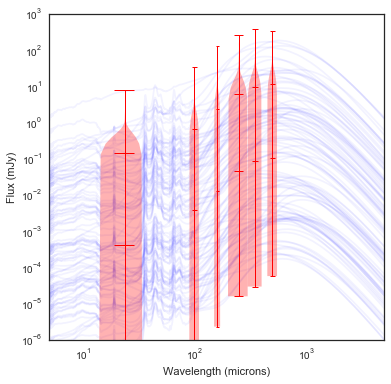

In [358]:
import pandas as pd
SEDS_IR_full=pd.read_pickle('SEDS_IR_full.pkl')
import seaborn as sns
sns.set_style("white")

plt.figure(figsize=(6,6))
s1=138
from astropy.cosmology import Planck13
violin_parts=plt.violinplot(samples[:,0:3,s1],[250,350,500], points=60, widths=100,
                      showmeans=True, showextrema=True, showmedians=True,bw_method=0.5)
# Make all the violin statistics marks red:
for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
    vp = violin_parts[partname]
    vp.set_edgecolor('red')
    vp.set_linewidth(1)

for pc in violin_parts['bodies']:
    pc.set_facecolor('red')

violin_parts=plt.violinplot(samples[:,3:,s1],[24,100,160], points=60, widths=20,
                      showmeans=True, showextrema=True, showmedians=True,bw_method=0.5)
# Make all the violin statistics marks red:
for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
    vp = violin_parts[partname]
    vp.set_edgecolor('red')
    vp.set_linewidth(1)

for pc in violin_parts['bodies']:
    pc.set_facecolor('red')

from astropy.cosmology import Planck13

import astropy.units as u


for s in range(0,100,1):
    
    div=(4.0*np.pi * np.square(Planck13.luminosity_distance(z_prior[s,s1]).cgs))
    div=div.value
    plt.loglog((z_prior[i,s1]+1.0)*SEDS_IR_full['wave'],
           np.power(10.0,LIR_prior[s,s1])*(1.0+z_prior[s,s1])
           *SEDS_IR_full[SEDS_IR_full.columns[np.arange(1,SEDs_IR.shape[0]+1)
                                        [SED_prior[s,s1]==1]]]/div,alpha=0.05,c='b',zorder=0)
    
    #plt.plot([250,350,500, 24,100,160],posterior_IR.samples['src_f'][s,0:6,s1], 'ko', alpha=0.1, ms=10)
    #plt.plot([250,350,500],posterior.samples['src_f'][s,0:3,s1], 'ro', alpha=0.1, ms=10)
    


plt.ylim(10E-7,10E2)
plt.xlim(5,5E3)
#plt.plot([3.6,4.5,5.7,7.9],[2.91E-3,2.38E-3,2.12E-3,9.6E-3], 'ro')
plt.xlabel('Wavelength (microns)')
plt.ylabel('Flux (mJy)')